# Amazon Personalize Generic Module - Model Layer

In [ ]:
!pip install -q boto3

In [ ]:
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws

In Amazon Personalize, a specific variation of an algorithm is called a recipe. Different recipes are suitable for different situations. A trained model is called a solution, and each solution can have many versions that relate to a given volume of data when the model was trained.

In this notebook, you will train several models using Amazon Personalize, specifically:
1. User Personalization - what items are most relevant to a specific user.
2. Similar Items - given an item, what items are similar to it.
3. Personalized Ranking - given a user and a collection of items, in what order are they most releveant.

In [ ]:
import pickle
import time
from time import sleep
import json
from datetime import datetime
import uuid
import random
import pandas as pd

import boto3
import botocore
from botocore.exceptions import ClientError

from generic_modules.import_dataset import personalize_dataset

In [ ]:
# Loading old state containing resouce arns
with open('./artifacts/etc/personalize_item_meta.pkl', 'rb') as outp:
    personalize_item_meta = pickle.load(outp)

In [ ]:
# Configure the SDK to Personalize
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

In [ ]:
personalize.list_recipes()

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '1259',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 28 Aug 2021 17:10:21 GMT',
   'x-amzn-requestid': '25338267-d8e0-45bb-8c33-5d2e38149681'},
  'HTTPStatusCode': 200,
  'RequestId': '25338267-d8e0-45bb-8c33-5d2e38149681',
  'RetryAttempts': 0},
 'recipes': [{'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2021, 8, 11, 15, 2, 36, 642000, tzinfo=tzlocal()),
   'name': 'aws-hrnn',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn',
   'status': 'ACTIVE'},
  {'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2021, 8, 11, 15, 2, 36, 642000, tzinfo=tzlocal()),
   'name': 'aws-hrnn-coldstart',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-coldstart',
   'status': 'ACTIVE'},
  {'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0

In [ ]:
# define the solution arn
user_personalization_recipe_arn = "arn:aws:personalize:::recipe/aws-user-personalization"

In [ ]:
# Create the solution
"""First you create a solution using the recipe. Although you provide
the dataset ARN in this step, the model is not yet trained. See this as
an identifier instead of a trained model."""

user_personalization_create_solution_response = personalize.create_solution(
    name = "personalize-poc-userpersonalization",
    datasetGroupArn = personalize_item_meta.dataset_group_arn,
    recipeArn = user_personalization_recipe_arn
)

user_personalization_solution_arn = user_personalization_create_solution_response['solutionArn']
user_personalization_solution_arn

"arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-userpersonalization"


The training can take a while to complete,
upwards of 25 minutes, and an average of 90 minutes for this recipe with
our dataset. Normally, we would use a while loop to poll until the task is
completed. However the task would block other cells from executing, and the
goal here is to create many models and deploy them quickly. So we will set
up the while loop for all of the solutions further down in the notebook. There,
you will also find instructions for viewing the progress in the AWS console.

In [ ]:
# Create the solution version
"""Once you have a solution, you need to create a version in order to
complete the model training."""

userpersonalization_create_solution_version_response = personalize.create_solution_version(
    solutionArn = user_personalization_solution_arn
)
userpersonalization_solution_version_arn = userpersonalization_create_solution_version_response['solutionVersionArn']
userpersonalization_solution_version_arn

'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-userpersonalization/3b593c5b'

### SIMS Recipe

In [ ]:
SIMS_recipe_arn = "arn:aws:personalize:::recipe/aws-sims"

sims_create_solution_response = personalize.create_solution(
    name = "personalize-poc-sims",
    datasetGroupArn = personalize_item_meta.dataset_group_arn,
    recipeArn = SIMS_recipe_arn
)

sims_solution_arn = sims_create_solution_response['solutionArn']
sims_solution_arn

'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-sims'

In [ ]:
sims_create_solution_version_response = personalize.create_solution_version(
    solutionArn = sims_solution_arn
)

sims_solution_version_arn = sims_create_solution_version_response['solutionVersionArn']
sims_solution_version_arn

'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-sims/edb3d46e'

### Ranking Recipe

In [ ]:
rerank_recipe_arn = "arn:aws:personalize:::recipe/aws-personalized-ranking"

rerank_create_solution_response = personalize.create_solution(
    name = "personalize-poc-rerank",
    datasetGroupArn = personalize_item_meta.dataset_group_arn,
    recipeArn = rerank_recipe_arn
)

rerank_solution_arn = rerank_create_solution_response['solutionArn']
rerank_solution_arn

'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-rerank'

In [ ]:
rerank_create_solution_version_response = personalize.create_solution_version(
    solutionArn = rerank_solution_arn
)
rerank_solution_version_arn = rerank_create_solution_version_response['solutionVersionArn']
rerank_solution_version_arn

'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-rerank/e3e81151'

## Check the status

In [ ]:
in_progress_solution_versions = [
    userpersonalization_solution_version_arn,
    sims_solution_version_arn,
    rerank_solution_version_arn
]

max_time = time.time() + 10*60*60 # 10 hours
while time.time() < max_time:
    for solution_version_arn in in_progress_solution_versions:
        version_response = personalize.describe_solution_version(
            solutionVersionArn = solution_version_arn
        )
        status = version_response["solutionVersion"]["status"]
        
        if status == "ACTIVE":
            print("Build succeeded for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
    
    if len(in_progress_solution_versions) <= 0:
        break
    else:
        print("At least one solution build is still in progress")
        
    time.sleep(60)

At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
Build succeeded for arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-sims/edb3d46e
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
Build succeeded for arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-userpersonalization/3b593c

## Hyperparameter tuning

In [ ]:
sims_create_solution_response = personalize.create_solution(
    name = "personalize-poc-sims-hpo",
    datasetGroupArn = dataset_group_arn,
    recipeArn = SIMS_recipe_arn,
    performHPO=True
)

If you already know the values you want to use for a specific hyperparameter, you can also set this value when you create the solution. The code below shows how you could set the value for the popularity_discount_factor for the SIMS recipe.

In [ ]:
sims_create_solution_response = personalize.create_solution(
    name = "personalize-poc-sims-set-hp",
    datasetGroupArn = dataset_group_arn,
    recipeArn = SIMS_recipe_arn,
    solutionConfig = {
        'algorithmHyperParameters': {
            'popularity_discount_factor': '0.7'
        }
    }
)

## Evaluation

In [ ]:
user_personalization_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = userpersonalization_solution_version_arn
)

In [ ]:
user_personalization_solution_metrics_response

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '419',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 28 Aug 2021 18:30:27 GMT',
   'x-amzn-requestid': '3ef75e51-e9cb-4baa-b2b6-133799a87608'},
  'HTTPStatusCode': 200,
  'RequestId': '3ef75e51-e9cb-4baa-b2b6-133799a87608',
  'RetryAttempts': 0},
 'metrics': {'coverage': 0.0719,
  'mean_reciprocal_rank_at_25': 0.2676,
  'normalized_discounted_cumulative_gain_at_10': 0.2684,
  'normalized_discounted_cumulative_gain_at_25': 0.3237,
  'normalized_discounted_cumulative_gain_at_5': 0.2409,
  'precision_at_10': 0.0482,
  'precision_at_25': 0.0329,
  'precision_at_5': 0.0679},
 'solutionVersionArn': 'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-userpersonalization/3b593c5b'}

## Deploying Campaigns and Filters

In [ ]:
# Establish a connection to Personalize's event streaming
personalize_events = boto3.client(service_name='personalize-events')

In [ ]:
userpersonalization_create_campaign_response = personalize.create_campaign(
    name = "personalize-poc-userpersonalization",
    solutionVersionArn = userpersonalization_solution_version_arn,
    minProvisionedTPS = 1
)

In [ ]:
userpersonalization_campaign_arn = userpersonalization_create_campaign_response['campaignArn']
userpersonalization_campaign_arn

'arn:aws:personalize:us-east-1:746888961694:campaign/personalize-poc-userpersonalization'

## View Campaign Creation Status

In [ ]:
in_progress_campaigns = [
    userpersonalization_campaign_arn
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for campaign_arn in in_progress_campaigns:
        version_response = personalize.describe_campaign(
            campaignArn = campaign_arn
        )
        status = version_response["campaign"]["status"]
        
        if status == "ACTIVE":
            print("Build succeeded for {}".format(campaign_arn))
            in_progress_campaigns.remove(campaign_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(campaign_arn))
            in_progress_campaigns.remove(campaign_arn)
    
    if len(in_progress_campaigns) <= 0:
        break
    else:
        print("At least one campaign build is still in progress")
        
    time.sleep(60)

## Create Static Filters

In [ ]:
creategenrefilter_response = personalize.create_filter(name='Genre',
    datasetGroupArn=dataset_group_arn,
    filterExpression='INCLUDE ItemID WHERE Items.GENRE IN ($GENRE)'
    )
genre_filter_arn = creategenrefilter_response['filterArn']

decades_to_filter = [1950,1960,1970,1980,1990,2000,2010]

# Create a list for the filters:
meta_filter_decade_arns = []

# Iterate through Genres
for decade in decades_to_filter:
    # Start by creating a filter
    current_decade = str(decade)
    next_decade = str(decade + 10)
    try:
        createfilter_response = personalize.create_filter(
            name=current_decade + "s",
            datasetGroupArn=dataset_group_arn,
            filterExpression='INCLUDE ItemID WHERE Items.YEAR >= '+ current_decade +' AND Items.YEAR < '+ next_decade +''
    )
        # Add the ARN to the list
        meta_filter_decade_arns.append(createfilter_response['filterArn'])
        print("Creating: " + createfilter_response['filterArn'])
    
    # If this fails, wait a bit
    except ClientError as error:
        # Here we only care about raising if it isnt the throttling issue
        if error.response['Error']['Code'] != 'LimitExceededException':
            print(error)
        else:    
            time.sleep(120)
            createfilter_response = personalize.create_filter(
                name=current_decade + "s",
                datasetGroupArn=dataset_group_arn,
                filterExpression='INCLUDE ItemID WHERE Items.YEAR >= '+ current_decade +' AND Items.YEAR < '+ next_decade +''
    )
            # Add the ARN to the list
            meta_filter_decade_arns.append(createfilter_response['filterArn'])
            print("Creating: " + createfilter_response['filterArn'])

In [ ]:
# Lets also create 2 event filters for watched and unwatched content

createwatchedfilter_response = personalize.create_filter(name='watched',
    datasetGroupArn=dataset_group_arn,
    filterExpression='INCLUDE ItemID WHERE Interactions.event_type IN ("watch")'
    )

createunwatchedfilter_response = personalize.create_filter(name='unwatched',
    datasetGroupArn=dataset_group_arn,
    filterExpression='EXCLUDE ItemID WHERE Interactions.event_type IN ("watch")'
    )

interaction_filter_arns = [createwatchedfilter_response['filterArn'], createunwatchedfilter_response['filterArn']]

## Generic Module

In [ ]:
from generic_modules.import_model import personalize_model

### User Personalization Model

In [ ]:
dataset_group_arn = 'arn:aws:personalize:us-east-1:746888961694:dataset-group/immersion-day-dataset-group-movielens-latest'
solution_arn = 'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-sims'
solution_version_arn = 'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-sims/edb3d46e'
campaign_arn = 'arn:aws:personalize:us-east-1:746888961694:campaign/personalize-poc-userpersonalization'

In [ ]:
pers_model = personalize_model(dataset_group_arn = dataset_group_arn,
                               solution_arn = solution_arn,
                               solution_version_arn = solution_version_arn,
                               campaign_arn = campaign_arn)

In [ ]:
pers_model.setup_connection()

SUCCESS | We can communicate with Personalize!


In [ ]:
pers_model.recipe_list()

['aws-hrnn',
 'aws-hrnn-coldstart',
 'aws-hrnn-metadata',
 'aws-personalized-ranking',
 'aws-popularity-count',
 'aws-sims',
 'aws-user-personalization']

In [ ]:
pers_model.check_campaign_creation_status()

'ACTIVE'

In [ ]:
pers_model.create_filter(name='Genre', expression='INCLUDE ItemID WHERE Items.GENRE IN ($GENRE)')
pers_model.create_filter(name='watched', expression='INCLUDE ItemID WHERE Interactions.event_type IN ("watch")')
pers_model.create_filter(name='unwatched', expression='EXCLUDE ItemID WHERE Interactions.event_type IN ("watch")')

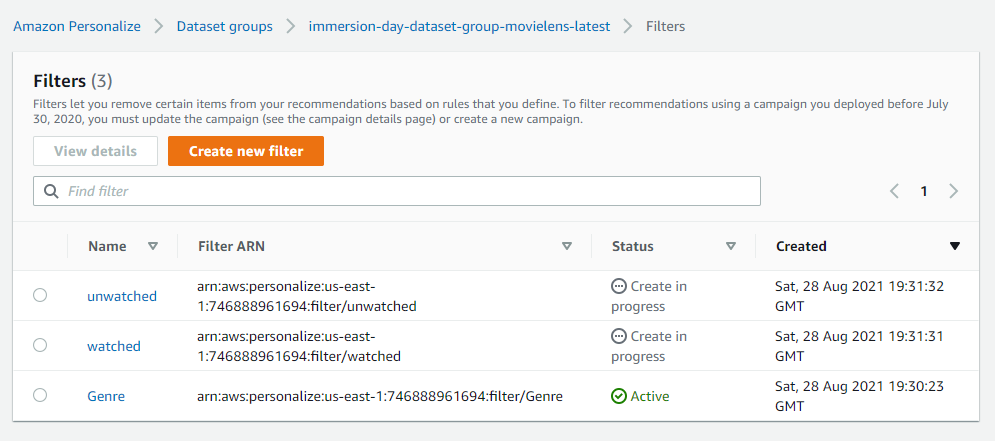

### SIMS Model

In [ ]:
dataset_group_arn = 'arn:aws:personalize:us-east-1:746888961694:dataset-group/immersion-day-dataset-group-movielens-latest'
solution_arn = 'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-sims'
solution_version_arn = 'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-sims/edb3d46e'

In [ ]:
sims_model = personalize_model(dataset_group_arn = dataset_group_arn,
                               solution_arn = solution_arn,
                               solution_version_arn = solution_version_arn)

In [ ]:
sims_model.setup_connection()

SUCCESS | We can communicate with Personalize!


In [ ]:
sims_model.get_evaluation_metrics()['metrics']

{'coverage': 0.1882,
 'mean_reciprocal_rank_at_25': 0.1437,
 'normalized_discounted_cumulative_gain_at_10': 0.1666,
 'normalized_discounted_cumulative_gain_at_25': 0.2172,
 'normalized_discounted_cumulative_gain_at_5': 0.1325,
 'precision_at_10': 0.0478,
 'precision_at_25': 0.0359,
 'precision_at_5': 0.058}

In [ ]:
sims_model.create_campaign(name='personalize-poc-sims-campaign')

In [ ]:
sims_model.check_campaign_creation_status()

'ACTIVE'

### Popularity Model

In [ ]:
dataset_group_arn = 'arn:aws:personalize:us-east-1:746888961694:dataset-group/immersion-day-dataset-group-movielens-latest'

In [ ]:
pop_model = personalize_model(dataset_group_arn = dataset_group_arn)

In [ ]:
pop_model.setup_connection()

SUCCESS | We can communicate with Personalize!


In [ ]:
pop_model.recipe_list()

['aws-hrnn',
 'aws-hrnn-coldstart',
 'aws-hrnn-metadata',
 'aws-personalized-ranking',
 'aws-popularity-count',
 'aws-sims',
 'aws-user-personalization']

In [ ]:
pop_model.create_solution(name='aws-popularity-count')

In [ ]:
pop_model.create_solution_version()

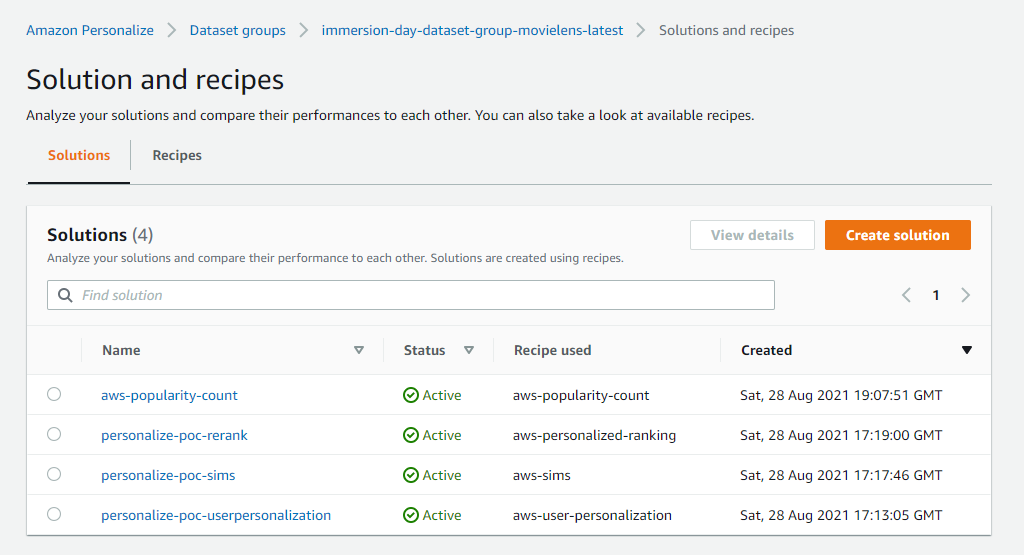

In [ ]:
pop_model.check_solution_version_status()

'CREATE IN_PROGRESS'

In [ ]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time: 
    status = pop_model.check_solution_version_status()
    print(status)
    if status=='ACTIVE':
        break
    time.sleep(30)

CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
ACTIVE


### Save States

In [ ]:
with open('./artifacts/etc/personalize_model_pers.pkl', 'wb') as outp:
    pickle.dump(pers_model, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./artifacts/etc/personalize_model_sims.pkl', 'wb') as outp:
    pickle.dump(sims_model, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./artifacts/etc/personalize_model_pop.pkl', 'wb') as outp:
    pickle.dump(pop_model, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
pers_model.__getstate__()

{'campaign_arn': 'arn:aws:personalize:us-east-1:746888961694:campaign/personalize-poc-userpersonalization',
 'dataset_group_arn': 'arn:aws:personalize:us-east-1:746888961694:dataset-group/immersion-day-dataset-group-movielens-latest',
 'filter_arns': ['arn:aws:personalize:us-east-1:746888961694:filter/watched',
  'arn:aws:personalize:us-east-1:746888961694:filter/unwatched'],
 'solution_arn': 'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-sims',
 'solution_version_arn': 'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-sims/edb3d46e'}

In [ ]:
sims_model.__getstate__()

{'campaign_arn': 'arn:aws:personalize:us-east-1:746888961694:campaign/personalize-poc-sims-campaign',
 'dataset_group_arn': 'arn:aws:personalize:us-east-1:746888961694:dataset-group/immersion-day-dataset-group-movielens-latest',
 'filter_arns': ['arn:aws:personalize:us-east-1:746888961694:filter/watched',
  'arn:aws:personalize:us-east-1:746888961694:filter/unwatched'],
 'solution_arn': 'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-sims',
 'solution_version_arn': 'arn:aws:personalize:us-east-1:746888961694:solution/personalize-poc-sims/edb3d46e'}

In [ ]:
pop_model.__getstate__()

{'campaign_arn': None,
 'dataset_group_arn': 'arn:aws:personalize:us-east-1:746888961694:dataset-group/immersion-day-dataset-group-movielens-latest',
 'filter_arns': ['arn:aws:personalize:us-east-1:746888961694:filter/watched',
  'arn:aws:personalize:us-east-1:746888961694:filter/unwatched'],
 'solution_arn': 'arn:aws:personalize:us-east-1:746888961694:solution/aws-popularity-count',
 'solution_version_arn': 'arn:aws:personalize:us-east-1:746888961694:solution/aws-popularity-count/44229eef'}

In [ ]:
import boto3
import json
import time


class personalize_inference:
    def __init__(self,
                 dataset_group_arn = None,
                 campaign_arn = None,
                 event_tracker_arn = None,
                 role_arn=None,
                 solution_version_arn=None,
                 batch_job_arn=None
                 ):
        self.personalize = None
        self.personalize_runtime = None
        self.personalize_events = None
        self.dataset_group_arn = dataset_group_arn
        self.campaign_arn = campaign_arn
        self.event_tracker_arn = event_tracker_arn
        self.event_tracker_id = event_tracker_id
        self.role_arn = role_arn
        self.solution_version_arn = solution_version_arn
        self.batch_job_arn = batch_job_arn

    def setup_connection(self):
        try:
            self.personalize = boto3.client('personalize')
            self.personalize_runtime = boto3.client('personalize-runtime')
            self.personalize_events = boto3.client(service_name='personalize-events')
            print("SUCCESS | We can communicate with Personalize!")
        except:
            print("ERROR | Connection can't be established!")

    def get_recommendations(self, itemid=None, userid=None, k=5,
                            filter_arn=None, filter_values=None):
        get_recommendations_response = self.personalize_runtime.get_recommendations(
            campaignArn = self.campaign_arn,
            itemId = str(itemid),
            userId = str(userid),
            filterArn = filter_arn,
            filterValues = filter_values,
            numResults = k
            )
        
    def get_rankings(self, userid=None, inputlist=None):
        get_recommendations_response = self.personalize_runtime.get_personalized_ranking(
            campaignArn = self.campaign_arn,
            userId = str(userid),
            inputList = inputlist
            )
        
    def create_event_tracker(self, name=None):
        response = self.personalize.create_event_tracker(
            name=name,
            datasetGroupArn=self.dataset_group_arn
            )
        self.event_tracker_arn = response['eventTrackerArn']
        self.event_tracker_id = response['trackingId']
    
    def put_events(self, userid=None, sessionid=None, eventlist=None):
        self.personalize_events.put_events(
            trackingId = self.event_tracker_id,
            userId = userid, 
            sessionId = sessionid,
            eventList = eventlist
            )
        
    def create_batch_job(self, jobname=None, input_path=None, output_path=None):
        response = self.personalize.create_batch_inference_job(
            solutionVersionArn = self.solution_version_arn,
            jobName = jobname,
            roleArn = self.role_arn,
            jobInput = {"s3DataSource": {"path": input_path}},
            jobOutput = {"s3DataDestination": {"path": output_path}}
            )
        self.batch_job_arn = response['batchInferenceJobArn']
    
    def check_batch_job_status(self):
        batch_job_response = self.personalize.describe_batch_inference_job(
        batchInferenceJobArn = self.batch_job_arn
        )
        status = batch_job_response["batchInferenceJob"]['status']
        return status

    def __getstate__(self):
        attributes = self.__dict__.copy()
        del attributes['personalize']
        del attributes['personalize_runtime']
        del attributes['personalize_events']
        return attributes